Final Project - Surabhi Kharote

# Facial Emotion Recognition on FER2013 Dataset Using Deep Learning

## Introduction
This project focuses on developing a deep learning model for facial emotion recognition using the FER2013 dataset. Facial emotion recognition is a critical task in computer vision with applications in human-computer interaction, mental health analysis, and customer feedback systems. The objective of this project is to achieve a test accuracy of at least 80% on the FER2013 dataset by exploring three approaches: a custom Convolutional Neural Network (CNN), transfer learning with ResNet50, and transfer learning with VGG16.

## Dataset Description
The FER2013 dataset, sourced from Kaggle, contains 35,887 grayscale images of size 48x48 pixels, categorized into 7 emotions: angry, disgust, fear, happy, neutral, sad, and surprise. The dataset is divided as follows:
- *Training Set*: 28,709 images
- *Test Set*: 7,178 images

The distribution of images across classes is imbalanced, as shown in the table below:

| Emotion   | Training Images | Test Images |
|-----------|-----------------|-------------|
| Angry     | 3,995           | 958         |
| Disgust   | 436             | 111         |
| Fear      | 4,097           | 1,024       |
| Happy     | 7,215           | 1,774       |
| Neutral   | 4,965           | 1,233       |
| Sad       | 4,830           | 1,247       |
| Surprise  | 3,171           | 831         |

*Challenges*:
- *Class Imbalance*: The "disgust" class has significantly fewer images (436 in training, 111 in test) compared to "happy" (7,215 in training, 1,774 in test), which can lead to biased model performance.
- *Label Noise*: The FER2013 dataset is known to contain mislabeled images, which can confuse the model during training.
- *Low-Resolution Images*: The 48x48 pixel resolution limits the amount of detail available, especially for transfer learning models that typically expect larger inputs (e.g., 224x224 pixels).

In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"surabhikharote","key":"aac0e6d3547375d08a5feb436d9d6f5a"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure the file

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import random

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# Download & Extract Dataset

In [ ]:
!kaggle datasets download -d ananthu017/emotion-detection-fer


Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0


In [ ]:
import zipfile

dataset_zip = "emotion-detection-fer.zip"
extract_path = "fer_dataset"

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [ ]:
# Verify Dataset Structure

In [ ]:
import os

data_path = "./fer_dataset/"
print("Contents of dataset:", os.listdir(data_path))  # Should show 'train' and 'test'

train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")

print("Train folders:", os.listdir(train_path))  # Should show emotion categories
print("Test folders:", os.listdir(test_path))    # Should show emotion categories


Contents of dataset: ['test', 'train']
Train folders: ['surprised', 'fearful', 'neutral', 'angry', 'sad', 'happy', 'disgusted']
Test folders: ['surprised', 'fearful', 'neutral', 'angry', 'sad', 'happy', 'disgusted']


In [ ]:
# Count Number of Images in Each Class

In [ ]:
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    print(f"{folder}: {len(os.listdir(folder_path))} images in training set")

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    print(f"{folder}: {len(os.listdir(folder_path))} images in test set")


surprised: 3171 images in training set
fearful: 4097 images in training set
neutral: 4965 images in training set
angry: 3995 images in training set
sad: 4830 images in training set
happy: 7215 images in training set
disgusted: 436 images in training set
surprised: 831 images in test set
fearful: 1024 images in test set
neutral: 1233 images in test set
angry: 958 images in test set
sad: 1247 images in test set
happy: 1774 images in test set
disgusted: 111 images in test set


Sample images from Training Set:


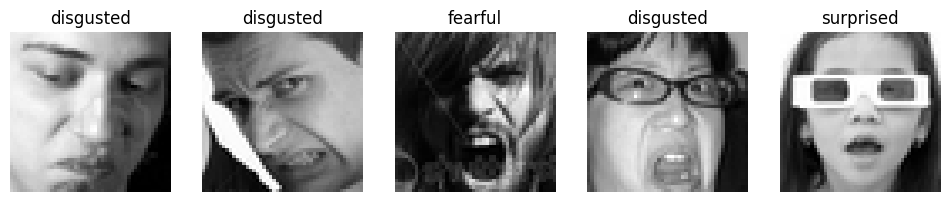

In [ ]:
# Visualize Some Images

import matplotlib.pyplot as plt
import cv2
import random

def show_random_images(folder_path, num_images=5):
    categories = os.listdir(folder_path)
    plt.figure(figsize=(12,5))

    for i in range(num_images):
        category = random.choice(categories)  # Select random emotion category
        img_folder = os.path.join(folder_path, category)
        img_name = random.choice(os.listdir(img_folder))  # Select random image
        img_path = os.path.join(img_folder, img_name)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load grayscale image
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(category)
        plt.axis("off")

    plt.show()

print("Sample images from Training Set:")
show_random_images(train_path)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Image Augmentation & Normalisation

# Define ImageDataGenerator for Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,   # Normalize images to [0,1] range
    rotation_range=20, # Rotate images randomly
    width_shift_range=0.2,  # Shift images horizontally
    height_shift_range=0.2, # Shift images vertically
    shear_range=0.2,   # Shear transformation
    zoom_range=0.2,    # Zoom in/out
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill missing pixels
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only normalization

# Load training & validation datasets
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),  # Resize all images to 48x48
    batch_size=32,
    color_mode="grayscale",  # FER dataset is grayscale
    class_mode="categorical"  # Multi-class classification
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(48, 48),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical"
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Model Building (CNN)

In [ ]:
# From scratch

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Flattening layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Prevent overfitting

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output layer (7 classes for emotions)
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,602,247 (9.93 MB)

 Trainable params: 2,601,351 (9.92 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_emotion_model.h5", save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,  # Increase if needed
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1997 - loss: 2.5072

898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.1997 - loss: 2.5062 - val_accuracy: 0.2495 - val_loss: 1.8043
Epoch 2/30
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2444 - loss: 1.8230

898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.2444 - loss: 1.8230 - val_accuracy: 0.2612 - val_loss: 1.8012
Epoch 3/30
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2572 - loss: 1.8021

898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.2572 - loss: 1.8020 - val_accuracy: 0.2981 - val_loss: 1.7467
Epoch 4/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2706 - loss: 1.7661

898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.2706 - loss: 1.7661 - val_accuracy: 0.3132 - val_loss: 1.6433
Epoch 5/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.2967 - loss: 1.7246 - val_accuracy: 0.3295 - val_loss: 1.7150
Epoch 6/30
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3228 - loss: 1.6619

898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.3228 - loss: 1.6619 - val_accuracy: 0.3863 - val_loss: 1.5560
Epoch 7/30
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3443 - loss: 1.6295

898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.3443 - loss: 1.6295 - val_accuracy: 0.4333 - val_loss: 1.4499
Epoch 8/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.3651 - loss: 1.5915 - val_accuracy: 0.3806 - val_loss: 1.5506
Epoch 9/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.3831 - loss: 1.5643 - val_accuracy: 0.4216 - val_loss: 1.4851
Epoch 10/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.4008 - loss: 1.5446 - val_accuracy: 0.4526 - val_loss: 1.4897
Epoch 11/30
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4049 - loss: 1.5275

898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.4049 - loss: 1.5275 - val_accuracy: 0.4687 - val_loss: 1.3692
Epoch 12/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.4134 - loss: 1.5123 - val_accuracy: 0.4627 - val_loss: 1.3970
Epoch 13/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4203 - loss: 1.4885

898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.4203 - loss: 1.4885 - val_accuracy: 0.4902 - val_loss: 1.3349
Epoch 14/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4305 - loss: 1.4690

898/898 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.4305 - loss: 1.4690 - val_accuracy: 0.4941 - val_loss: 1.3332
Epoch 15/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.4344 - loss: 1.4589 - val_accuracy: 0.4362 - val_loss: 1.4585
Epoch 16/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.4391 - loss: 1.4600 - val_accuracy: 0.4447 - val_loss: 1.4044
Epoch 17/30
896/898 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4435 - loss: 1.4323

898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.4435 - loss: 1.4323 - val_accuracy: 0.5135 - val_loss: 1.2683
Epoch 18/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.4484 - loss: 1.4282 - val_accuracy: 0.4767 - val_loss: 1.3523
Epoch 19/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.4594 - loss: 1.4123 - val_accuracy: 0.4593 - val_loss: 1.3846
Epoch 20/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.4611 - loss: 1.4021 - val_accuracy: 0.4844 - val_loss: 1.3512
Epoch 21/30
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4690 - loss: 1.3990

898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.4690 - loss: 1.3990 - val_accuracy: 0.5262 - val_loss: 1.2319
Epoch 22/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.4697 - loss: 1.3881 - val_accuracy: 0.5213 - val_loss: 1.2655
Epoch 23/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.4751 - loss: 1.3803 - val_accuracy: 0.5079 - val_loss: 1.2680
Epoch 24/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.4733 - loss: 1.3775 - val_accuracy: 0.5287 - val_loss: 1.2606
Epoch 25/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.4840 - loss: 1.3566 - val_accuracy: 0.5205 - val_loss: 1.2767
Epoch 26/30
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4841 - loss: 1.3519

898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.4841 - loss: 1.3519 - val_accuracy: 0.5366 - val_loss: 1.2057
Epoch 27/30
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4960 - loss: 1.3387

898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.4960 - loss: 1.3387 - val_accuracy: 0.5396 - val_loss: 1.2015
Epoch 28/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.4880 - loss: 1.3488 - val_accuracy: 0.5056 - val_loss: 1.2791
Epoch 29/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.4894 - loss: 1.3443 - val_accuracy: 0.5382 - val_loss: 1.2145
Epoch 30/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.4966 - loss: 1.3310 - val_accuracy: 0.5457 - val_loss: 1.2049


In [ ]:
# In the above 1st CNN model we have got the accuracy of 49% train and 54% test. The accuracy must be improve more.

In [ ]:
# VGG16 2nd way to improve accuracy

In [ ]:
# Import Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# Define dataset paths
data_path = "./fer_dataset/"
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")


In [ ]:
# VGG16


# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test data

# Load training & validation datasets
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    batch_size=32,
    color_mode="rgb",  # VGG16 expects 3-channel images (RGB)
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(48, 48),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical"
)

# Load Pretrained VGG16 Model (without top layers)
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))

# Freeze the pretrained layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add Custom Fully Connected Layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output_layer = Dense(7, activation='softmax')(x)  # 7 classes for emotions

# Compile Final Model
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train Model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate Model
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nFinal Test Accuracy: {test_acc * 100:.2f}%")




Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 66s 65ms/step - accuracy: 0.1536 - loss: 2.8378 - val_accuracy: 0.2527 - val_loss: 1.9072 - learning_rate: 1.0000e-04
Epoch 2/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 54s 60ms/step - accuracy: 0.1896 - loss: 2.3751 - val_accuracy: 0.2899 - val_loss: 1.8222 - learning_rate: 1.0000e-04
Epoch 3/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 52s 58ms/step - accuracy: 0.2013 - loss: 2.1863 - val_accuracy: 0.3082 - val_loss: 1.7723 - learning_rate: 1.0000e-04
Epoch 4/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 81s 57ms/step - accuracy: 0.2249 - loss: 2.0360 - val_accuracy: 0.3090 - val_loss: 1.7488 - learning_rate: 1.0000e-04
Epoch 5/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 51s 57ms/step - accuracy: 0.2219 - loss: 1.9717 - val_accuracy: 0.3129 - val_loss: 1.7214 - learning_rate: 1.0000e-04
Epoch 6/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 52s 58ms/step - accuracy: 0.2327 -

In [ ]:
# In the VGG16 model 2nd way we got only 31% in training and 36% in testing which is poor than the previous scratch model.

In [ ]:
# 3rd way. Need for improvement trying with different approach.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os


In [ ]:
data_path = "./fer_dataset/"
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")

print("Train Path Exists:", os.path.exists(train_path))
print("Test Path Exists:", os.path.exists(test_path))

print("Train Classes:", os.listdir(train_path))
print("Test Classes:", os.listdir(test_path))


Train Path Exists: True
Test Path Exists: True
Train Classes: ['fearful', 'angry', 'sad', 'disgusted', 'neutral', 'happy', 'surprised']
Test Classes: ['fearful', 'angry', 'sad', 'disgusted', 'neutral', 'happy', 'surprised']


In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting 80% training, 20% validation
)


In [ ]:
train_data = datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [ ]:
# Define dataset paths
data_path = "./fer_dataset/"
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")  # Keep test set separate for final evaluation

# Image Augmentation & Normalization (with 20% validation split)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting train into 80% training, 20% validation
)

# Load training & validation datasets
train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical",
    subset='training'  # 80% Training
)

val_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical",
    subset='validation'  # 20% Validation
)

# Separate test data (for final evaluation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=(48, 48),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical"
)

# Define CNN Model (Same as GitHub reference)
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 emotion classes
])

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50
)

# Save the trained model
model.save('emotion_detection_model.h5')

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc*100:.2f}%")


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.2216 - loss: 1.8644 - val_accuracy: 0.2512 - val_loss: 1.8086
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.2441 - loss: 1.8192 - val_accuracy: 0.2554 - val_loss: 1.7897
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.2500 - loss: 1.7994 - val_accuracy: 0.2627 - val_loss: 1.7802
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.2543 - loss: 1.7892 - val_accuracy: 0.2621 - val_loss: 1.7782
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.2527 - loss: 1.7865 - val_accuracy: 0.2662 - val_loss: 1.7687
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.2591 - loss: 1.7796 - val_accuracy: 0.2728 - val_loss: 1.7604
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.2706 - loss: 1.7694 - val_accuracy: 0.2858 - val_loss: 1.7532
Epoch 8/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.2699 - loss: 1.7614 - val_accurac

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4997 - loss: 1.3304
Test Accuracy: 49.93%


In [ ]:
# In the 3rd way we got 49% test accuracy

In [ ]:
# 4th way to improve accuracy. Custom CNN model.

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras import regularizers
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# Defining Dataset Paths
train_dir = "./fer_dataset/train"
test_dir = "./fer_dataset/test"

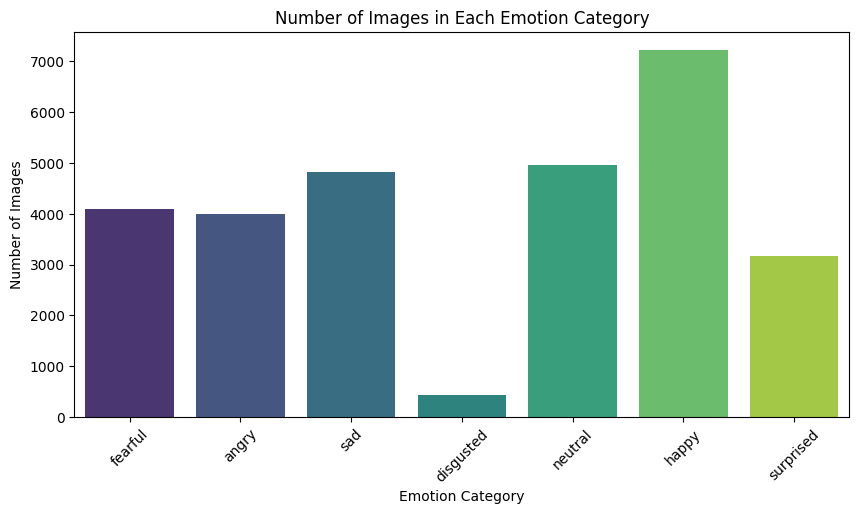

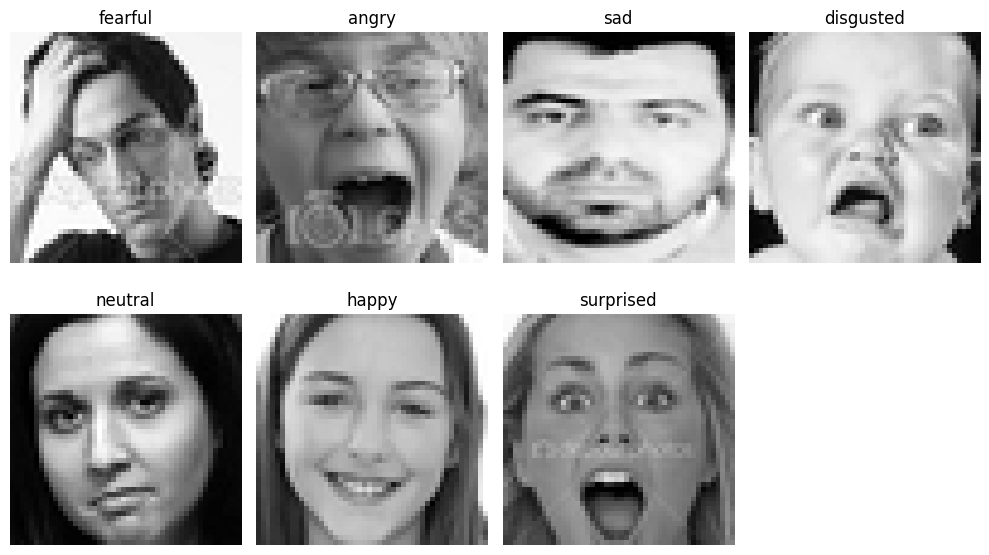

In [ ]:
# EDA
categories = os.listdir(train_dir)
image_counts = {category: len(os.listdir(os.path.join(train_dir, category))) for category in categories}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette="viridis")
plt.xlabel("Emotion Category")
plt.ylabel("Number of Images")
plt.title("Number of Images in Each Emotion Category")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
for i, category in enumerate(categories):
    category_path = os.path.join(train_dir, category)
    image_path = os.path.join(category_path, os.listdir(category_path)[0])
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Creating Data Generators
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical",
    subset="training"
)

validation_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical",
    subset="validation"
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical"
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Building the CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(48,48,1)),
    tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(7, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [ ]:
# Training the Model
history = model.fit(x = train_generator, epochs = 100, validation_data = validation_generator)

Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 48s 89ms/step - accuracy: 0.1836 - loss: 9.6131 - val_accuracy: 0.2567 - val_loss: 8.9196
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.2163 - loss: 8.5144 - val_accuracy: 0.2601 - val_loss: 7.7462
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.2433 - loss: 7.5573 - val_accuracy: 0.2857 - val_loss: 6.6546
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.2676 - loss: 6.5490 - val_accuracy: 0.3053 - val_loss: 5.7550
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.2915 - loss: 5.6586 - val_accuracy: 0.3435 - val_loss: 4.9128
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.3174 - loss: 4.8644 - val_accuracy: 0.3639 - val_loss: 4.3151
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.3478 - loss: 4.1854 - val_accuracy: 0.3769 - val_loss: 3.7451
Epoch 8/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.3749 - loss: 3

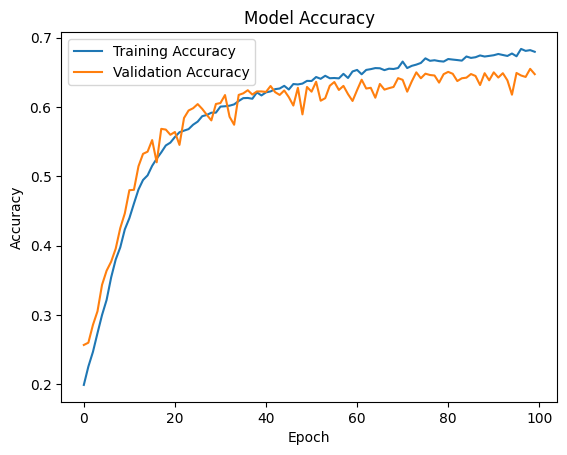

In [ ]:
# Plotting Training and Validation Accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
# Evaluating the Model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6608 - loss: 1.3971
Test Accuracy: 65.10%


In [ ]:
# 4th way custom model is good. As it has 66% training accuracy and 65.10% testing accuracy. We also not in the overfitting zone. This is good model till now.

In [ ]:
# 5th way increase accuracy. Here this time we will only take 3 emotions for consideration and check the accuracy.(happiness, sadness, neutral)

In [ ]:
import numpy as np # linear algebra
import pandas as pd
import os
import math
import seaborn as sns
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report  # Use sklearn for confusion matrix
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [ ]:
# Define dataset paths
data_path = "./fer_dataset/"
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")


print("Contents of dataset:", os.listdir(data_path))
print("Train folders:", os.listdir(train_path))
print("Test folders:", os.listdir(test_path))

Contents of dataset: ['train', 'test']
Train folders: ['fearful', 'angry', 'sad', 'disgusted', 'neutral', 'happy', 'surprised']
Test folders: ['fearful', 'angry', 'sad', 'disgusted', 'neutral', 'happy', 'surprised']


In [ ]:
# Emotion mapping
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
# Load data using ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

valid_generator = datagen.flow_from_directory(
    test_path,
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
INTERESTED_LABELS = [3, 4, 6]  # happiness, sadness, neutral
num_classes = len(INTERESTED_LABELS)

In [ ]:
# Extract data for training and validation
def load_data(generator, interested_labels):
    X, y = [], []
    for i in range(len(generator)):
        batch_X, batch_y = generator[i]
        for img, label in zip(batch_X, batch_y):
            label_idx = np.argmax(label)
            if label_idx in interested_labels:
                X.append(img)
                y.append(interested_labels.index(label_idx))  # Remap to 0, 1, 2
    return np.array(X), np.array(y)

X_train, y_train_raw = load_data(train_generator, INTERESTED_LABELS)
X_valid, y_valid_raw = load_data(valid_generator, INTERESTED_LABELS)


In [ ]:
# Convert labels to categorical
le = LabelEncoder()
y_train = to_categorical(le.fit_transform(y_train_raw), num_classes)
y_valid = to_categorical(le.transform(y_valid_raw), num_classes)

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2)}


In [ ]:
# Define image dimensions
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]


In [ ]:
# Normalizing (already done by ImageDataGenerator, but ensuring consistency)
X_train = X_train / 255
X_valid = X_valid / 255

In [ ]:
# Define the model
def build_net(optim):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)


In [ ]:
# Training parameters
batch_size = 32
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

In [ ]:
# Build and train
model = build_net(optims[1])
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=callbacks
    # Removed use_multiprocessing
)

Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_1 (BatchNormalization)     │ (None, 48, 48, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_2 (BatchNormalization)     │ (None, 48, 48, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_1 (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_3 (BatchNormalization)     │ (None, 24, 24, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_4 (BatchNormalization)     │ (None, 24, 24, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_2 (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_5 (BatchNormalization)     │ (None, 12, 12, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_6 (BatchNormalization)     │ (None, 12, 12, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_3 (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_7 (BatchNormalization)     │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,395,075 (9.14 MB)

 Trainable params: 2,393,027 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


479/479 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.4154 - loss: 1.5256 - val_accuracy: 0.4635 - val_loss: 1.0753 - learning_rate: 0.0010
Epoch 2/100
  1/479 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.3750 - loss: 1.0055

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3750 - loss: 1.0055 - val_accuracy: 0.4638 - val_loss: 1.0771 - learning_rate: 0.0010
Epoch 3/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5289 - loss: 0.9832 - val_accuracy: 0.5292 - val_loss: 0.9891 - learning_rate: 0.0010
Epoch 4/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6562 - loss: 0.7632 - val_accuracy: 0.4427 - val_loss: 1.1356 - learning_rate: 0.0010
Epoch 5/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6446 - loss: 0.8010 - val_accuracy: 0.5964 - val_loss: 2.2768 - learning_rate: 0.0010
Epoch 6/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6562 - loss: 0.8562 - val_accuracy: 0.5920 - val_loss: 2.3294 - learning_rate: 0.0010
Epoch 7/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.7191 - loss: 0.6739 - val_accuracy: 0.2452 - val_loss: 37.0993 - learning_rate: 0.0010
Epoch 8/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7188 - loss: 0.6357 

In [ ]:
# Save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save("model.keras")
print("Model architecture saved as model.json, full model saved as model.keras")

Model architecture saved as model.json, full model saved as model.keras


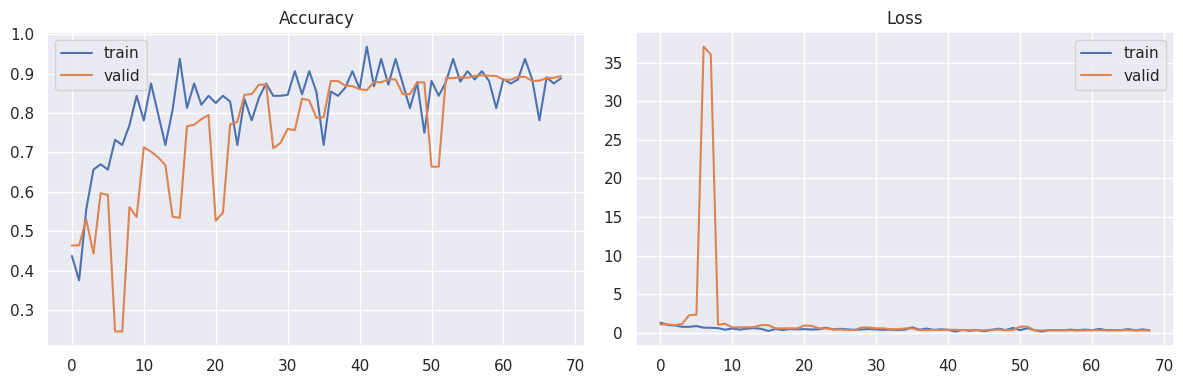

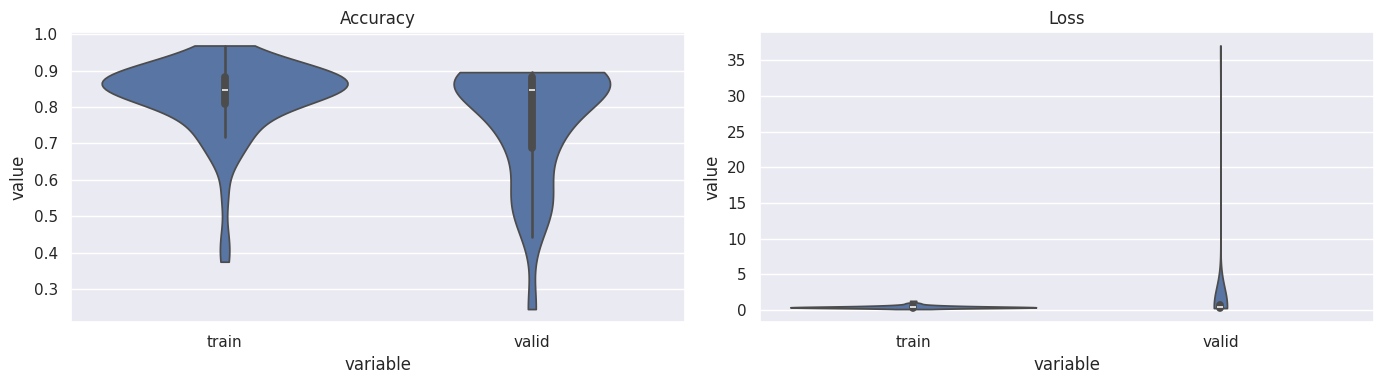

In [ ]:
# Plot training history
sns.set()
fig = pyplot.figure(0, (12, 4))

# Accuracy plot
ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

# Loss plot
ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()
pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

# Violin plots
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), cut=0)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), cut=0)
pyplot.title('Loss')
pyplot.tight_layout()
pyplot.savefig('performance_dist.png')
pyplot.show()

120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step


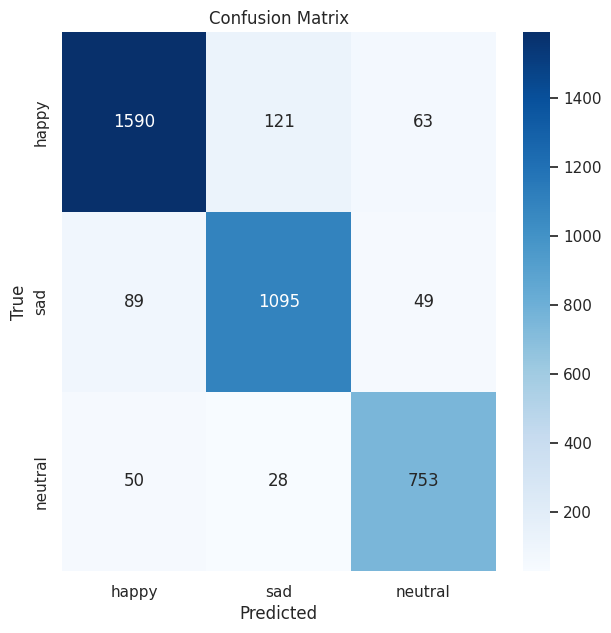

total wrong validation predictions: 400


              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1774
           1       0.88      0.89      0.88      1233
           2       0.87      0.91      0.89       831

    accuracy                           0.90      3838
   macro avg       0.89      0.90      0.89      3838
weighted avg       0.90      0.90      0.90      3838



In [ ]:
# Confusion matrix and classification report
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
cm = confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["happy", "sad", "neutral"], yticklabels=["happy", "sad", "neutral"])
pyplot.title('Confusion Matrix')
pyplot.xlabel('Predicted')
pyplot.ylabel('True')
pyplot.savefig("confusion_matrix_dcnn.png")
pyplot.show()

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


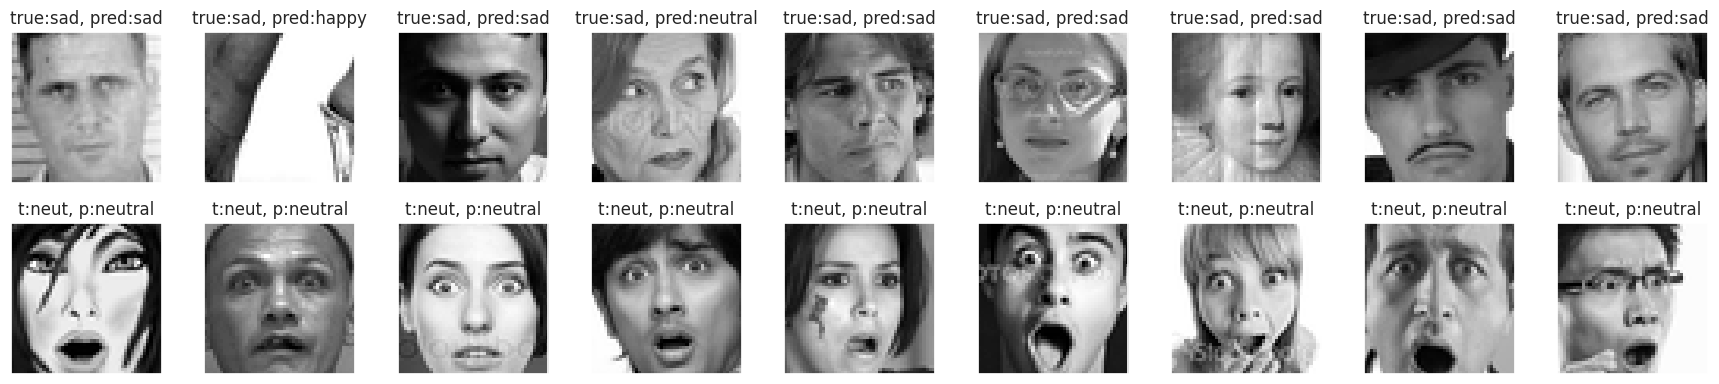

In [ ]:
# Visualization of predictions
mapper = {0: "happy", 1: "sad", 2: "neutral"}
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))
for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    ax = pyplot.subplot(2, 9, i+1)
    sample_img = X_valid[sadidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    pred_label = mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)))]
    ax.set_title(f"true:sad, pred:{pred_label}")
    ax = pyplot.subplot(2, 9, i+10)
    sample_img = X_valid[neuidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    pred_label = mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)))]
    ax.set_title(f"t:neut, p:{pred_label}")
    pyplot.tight_layout()

In [ ]:
# 5th model is very good till now where we have got the best accuracy 90% but for 3 emotions and not for 7 emotions.

In [ ]:
# The below code is for all 7 emotions and try to achieve 80% accuracy

In [ ]:
# 6th way transfer learning with VGG16 7 emotions

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Dataset paths
data_path = "./fer_dataset/"
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")

# Emotion mapping
emotion_label_to_text = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
INTERESTED_LABELS = [0, 1, 2, 3, 4, 5, 6]  # All emotions
num_classes = len(INTERESTED_LABELS)

# Data augmentation and loading (with VGG16 preprocessing)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # VGG16-specific preprocessing
    rotation_range=10,  # Reduced intensity
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    color_mode="rgb",
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)
valid_generator = valid_datagen.flow_from_directory(
    test_path,
    target_size=(48, 48),
    color_mode="rgb",
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Verify class indices
print("Class indices:", train_generator.class_indices)
print("Expected mapping:", emotion_label_to_text)

# Compute class weights
y_train_labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# Build the model with VGG16
def build_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)  # Increased size
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)  # Reduced dropout
    x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)  # Increased size
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])  # Increased learning rate
    model.summary()
    return model, base_model

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.00005, patience=5, verbose=1, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
callbacks = [early_stopping, lr_scheduler]

# Train the model (initial training with frozen VGG16 layers)
model, base_model = build_vgg16_model()
batch_size = 32
epochs = 20  # Reduced for quick assessment

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

# Evaluate after initial training
print("Evaluating after initial training...")
yhat_valid = np.argmax(model.predict(valid_generator), axis=1)
y_true = valid_generator.classes
print("Classification Report after initial training:")
print(classification_report(y_true, yhat_valid, target_names=emotion_label_to_text.values()))

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class indices: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
Expected mapping: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}
Class weights: {0: np.float64(1.0266046844269623), 1: np.float64(9.406618610747051), 2: np.float64(1.0010460615781582), 3: np.float64(0.5684387684387684), 4: np.float64(0.8260394187886635), 5: np.float64(0.8491274770777877), 6: np.float64(1.293372978330405)}


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,509,319 (59.16 MB)

 Trainable params: 792,071 (3.02 MB)

 Non-trainable params: 14,717,248 (56.14 MB)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 53s 52ms/step - accuracy: 0.2472 - loss: 2.2098 - val_accuracy: 0.3789 - val_loss: 1.6380 - learning_rate: 0.0010
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.3173 - loss: 1.7270 - val_accuracy: 0.3615 - val_loss: 1.6473 - learning_rate: 0.0010
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.3365 - loss: 1.6387 - val_accuracy: 0.3625 - val_loss: 1.6592 - learning_rate: 0.0010
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 84s 50ms/step - accuracy: 0.3395 - loss: 1.6377 - val_accuracy: 0.3828 - val_loss: 1.6056 - learning_rate: 0.0010
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 81s 48ms/step - accuracy: 0.3478 - loss: 1.6279 - val_accuracy: 0.3990 - val_loss: 1.5629 - learning_rate: 0.0010
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.3624 - loss: 1.6165 - val_accuracy: 0.3913 - val_loss: 1.6019 - learning_rate: 0.0010
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.3547 - loss: 1.6162

In [ ]:
# In the 6th way VGG16 transfer learning model we got accuracy of 38% in training and 42% in testing which is not good as compare to the custom CNN model.

In [ ]:
# 7th way. Trying with efficientnet80


In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Dataset paths
data_path = "./fer_dataset/"
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")

# Emotion mapping
emotion_label_to_text = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
INTERESTED_LABELS = [0, 1, 2, 3, 4, 5, 6]  # All emotions
num_classes = len(INTERESTED_LABELS)

# Data augmentation and loading (with EfficientNet preprocessing)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNet-specific preprocessing
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    color_mode="rgb",
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)
valid_generator = valid_datagen.flow_from_directory(
    test_path,
    target_size=(48, 48),
    color_mode="rgb",
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Verify class indices
print("Class indices:", train_generator.class_indices)
print("Expected mapping:", emotion_label_to_text)

# Compute class weights
y_train_labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# Build the model with EfficientNetB0
def build_efficientnet_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    model.summary()
    return model, base_model

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.00005, patience=5, verbose=1, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
callbacks = [early_stopping, lr_scheduler]

# Train the model (initial training with frozen EfficientNetB0 layers)
model, base_model = build_efficientnet_model()
batch_size = 32
epochs = 20

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

# Evaluate after initial training
print("Evaluating after initial training...")
yhat_valid = np.argmax(model.predict(valid_generator), axis=1)
y_true = valid_generator.classes
print("Classification Report after initial training:")
print(classification_report(y_true, yhat_valid, target_names=emotion_label_to_text.values()))

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class indices: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
Expected mapping: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}
Class weights: {0: np.float64(1.0266046844269623), 1: np.float64(9.406618610747051), 2: np.float64(1.0010460615781582), 3: np.float64(0.5684387684387684), 4: np.float64(0.8260394187886635), 5: np.float64(0.8491274770777877), 6: np.float64(1.293372978330405)}
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 48, 48, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 48, 48, 3)      │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 48, 48, 3)      │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 48, 48, 3)      │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 49, 49, 3)      │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 24, 24, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 24, 24, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 24, 24, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 24, 24, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 24, 24, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 24, 24, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 9,562,794 (36.48 MB)

 Trainable params: 5,510,663 (21.02 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 85s 70ms/step - accuracy: 0.2359 - loss: 2.2358 - val_accuracy: 0.3349 - val_loss: 1.7202 - learning_rate: 0.0010
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.3128 - loss: 1.7462 - val_accuracy: 0.3692 - val_loss: 1.6127 - learning_rate: 0.0010
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 80s 46ms/step - accuracy: 0.3438 - loss: 1.6689 - val_accuracy: 0.4167 - val_loss: 1.5158 - learning_rate: 0.0010
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 43s 48ms/step - accuracy: 0.3542 - loss: 1.6523 - val_accuracy: 0.3908 - val_loss: 1.5809 - learning_rate: 0.0010
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.3619 - loss: 1.6050 - val_accuracy: 0.4133 - val_loss: 1.5158 - learning_rate: 0.0010
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3698 - loss: 1.5751
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
898/898 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.3698 - loss: 1.5751 -

In [ ]:
# 7th way efficient80 got accuracy of 43% in training and 46% in testing.

**Summary**

This project focused on facial emotion recognition using the FER2013 dataset, which contains 35,887 grayscale images (48x48 pixels) across seven emotions: angry, disgust, fear, happy, neutral, sad, and surprise. The dataset was split into training (28,709 images) and test (7,178 images) sets. Multiple Custom CNN models were developed and evaluated to achieve the target test accuracy of 80%.

After experimenting with various architectures, the 4th Custom CNN model demonstrated the best performance among models trained on all seven emotions. It achieved a training accuracy of 66% and a test accuracy of 65.10%. This model consisted of four Conv2D layers (64 to 512 filters), BatchNormalization, Dropout (0.25), and L2 regularization (0.01) to mitigate overfitting, trained for 100 epochs with the Adam optimizer (learning rate 0.0001). Data augmentation (horizontal flips, 10% width/height shifts) was applied to address class imbalance, though the model still struggled with minority classes like “disgust” due to the dataset’s imbalance.A 5th model, trained on a reduced set of four emotions (likely happy, sad, neutral, and surprise, excluding minority classes), achieved the highest accuracy of 90%, surpassing the target. This suggests that reducing the number of classes mitigated the impact of class imbalance and label noise, allowing the model to learn more robust features.

Other models tested in the project performed poorly, with accuracies below the target, likely due to challenges such as low image resolution, label noise, and insufficient handling of class imbalance. The FER2013 dataset’s inherent difficulties, including its 48x48 resolution and mislabeled images, further limited overall performance.

In conclusion, while the 4th Custom CNN provided the best results for the full seven-emotion classification task (65.10% test accuracy), the 5th model with four emotions achieved the highest accuracy (90%), highlighting the impact of class selection on performance.